In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import MDAnalysis as mda
path="../outputs/contacts/"
def compute_avgs(cv,zdist,weights,nblocks=5):
    """compute_avgs
        Used to compute averages and errors of cv, given the weights and corresponding d_z at each timeframe. This allows to have two components of the error:
            1. related to difference between the membrane sides
            2. sum of two statistical errors coming from Bayesian Bootstrap
    cv: cv at each frame
    zdist: d_z of each frame
    weights: weight of each frame
    nblocks: number of blocks
    """

    err=np.zeros(2)
    obs=np.zeros(2)
    cv=np.asarray(cv)
    for i_sign,sign in enumerate([1,-1]):
        sel=zdist*sign>0
        cv_sel=cv[sel]
        weights_sel=weights[sel]
        obs[i_sign]=np.average(cv_sel,weights=weights_sel)
        err[i_sign]=b_bootstrap(cv_sel,len(cv_sel)//nblocks,weights_sel)[1]
    err_syst=np.std(obs)
    err_stat=np.std(err)
    error=(1/np.sqrt(2))*np.sqrt(err_syst**2+err_stat**2)
    avg=np.average(obs)
    return avg,error
#bayesian bootstrap
def b_bootstrap(cv,blocksize,weights,iter_numb=200):
    """b_bootstrap
        Performs bayesian bootstrap, to compute error of cv.

    cv: collective variable at each frame
    blocksize: size of the block
    weights: weight of each frame
    iter_numb: number of bootstrap iterations
    """
    nblocks = len(cv) // blocksize
    remainder = len(cv) % blocksize
    block_ids=np.arange(0,nblocks,1)

    if remainder>0:
        cv = cv[:-remainder]
        weights = weights[:-remainder]
    L= len(cv)
    cv=np.reshape(cv,(nblocks,blocksize))
    w=np.reshape(weights,(nblocks,blocksize))
    w_bootstrap=np.zeros((nblocks,iter_numb))
    avg=np.zeros(iter_numb)
    wflat=w.flatten()
    for r in range(iter_numb):
        block_selected=np.random.choice(block_ids,replace=True,size=len(block_ids))
        #w_bootstrap[:,r] = np.bincount(block_selected, minlength=nblocks) #this is just bootstrap
        w_bootstrap[:,r]=len(block_ids)*np.random.dirichlet(alpha=1*np.ones(len(block_ids)))
    for r in range(iter_numb):
        bias_r=np.repeat(w_bootstrap[:,r],L/nblocks)*wflat
        avg[r]=np.average(cv.flatten(),weights=bias_r)
    err=np.std(avg,axis=0)
    return np.average(np.ndarray.flatten(cv),weights=np.ndarray.flatten(weights)),err

def hbonds_mda(nucl,weights,zdist,byresidue=False):
    """hbonds_mda
    nucl: system name
    weights: weight of each frame
    zdist: d_z of each frame
    byresidue: used for quadruplex/strand analyses. it labels donors to distinguish A and G + counts hydrogen bonds made by A and G separately.
    """
    norm_neg=np.sum(weights[zdist<0])
    norm_pos=np.sum(weights[zdist>0])
    totnum_memb=[]
    acceptors={}
    donors={}
    if byresidue:
        nG=[]
        nA=[]
        hbond_by_res=[]
    hbonds_traj=np.loadtxt(path+"bound/hbonds/hbonds_traj_"+nucl+".dat")
    hbonds_count=np.loadtxt(path+"bound/hbonds/hbonds_count_"+nucl+".dat")
    times=np.unique(hbonds_traj[:,0])
    alltimes=hbonds_traj[:,0]
    i_traj=0 #This is the index related to the trajectory file which has less frames compared to the count (only displays formed hbonds)
    i_interaction=0
    for i_time in range(len(hbonds_count)):  #i_time iterates over the counts.
        if byresidue:
            count_G=0
            count_A=0
            hbond_by_res_frame=np.zeros(19)
        nhbonds=int(hbonds_count[i_time])
        saved_nhbonds=nhbonds
        if zdist[i_time]>0:
            norm=norm_pos
        else:
            norm=norm_neg
        if not nhbonds==0:
            checktime=hbonds_traj[i_traj,0]
            for i_interaction in range(i_traj,int(i_traj+nhbonds)): #You analyse a single timeframe.
                if not checktime == hbonds_traj[i_interaction,0]:
                    print("There is a mismatch between the timeframes: Results are wrong!")
                frame_hbond=hbonds_traj[i_interaction,1:]
                donor_id=int(frame_hbond[0]+1)
                acceptor_id=int(frame_hbond[2]+1) #maps are 1-based, mdanalysis is 0-based.
                acceptorname=maps[nucl][acceptor_id]   
                if not byresidue:
                    

                    donorname=maps[nucl][donor_id]
                    
                else:
                    don_resname=maps_resnames[nucl][donor_id]
                    donorname=don_resname+maps[nucl][donor_id]
                    don_resid=maps_resids[nucl][donor_id]
                    if don_resname.startswith('G'):
                        count_G+=1
                    elif don_resname.startswith('A'):
                        count_A+=1
                    hbond_by_res_frame[int(don_resid)-1]+=1
                if donorname not in acceptors:
                    acceptors[donorname]=(1/2)*weights[i_time]/norm #factor 1/2 comes from the fact that you consider the two sides of the membrane separately
                else:      
                    acceptors[donorname]+=(1/2)*weights[i_time]/norm                  
                if acceptorname not in donors:
                    donors[acceptorname]=(1/2)*weights[i_time]/norm
                else:    
                    donors[acceptorname]+=(1/2)*weights[i_time]/norm
            i_traj=i_interaction+1 # Update the index related to the trajectory file 
        totnum_memb.append(saved_nhbonds)
        if byresidue:
            nG.append(count_G)
            nA.append(count_A)
            hbond_by_res.append(hbond_by_res_frame)
    if not byresidue:

        return totnum_memb,acceptors
    else:
         return totnum_memb,acceptors,nG,nA,np.array(hbond_by_res) #you also store hbond_by_res to subtract H-bonds from vdW contacts
         
#Opens all conf.gro files in order to have a map between atom names and atom indices.
nucls=["A2","G2","U2","C2","A","G","U","C","quadruplex","strand","A3","G3","U3","C3"]
maps={}
maps_resnames={}
maps_resids={}
natoms={}
for nucl in nucls:
    maps[nucl]=["none"]
    maps_resnames[nucl]=["none"]
    maps_resids[nucl]=["none"]
    struct=mda.Universe("../inputs/"+nucl+"/conf.gro")
    for atom in struct.atoms:
        maps[nucl].append(atom.name)
        maps_resnames[nucl].append(atom.resname)
        maps_resids[nucl].append(atom.resid)

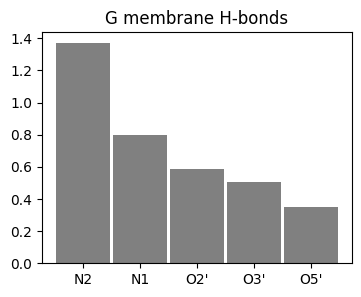

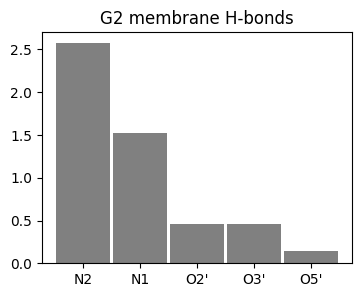

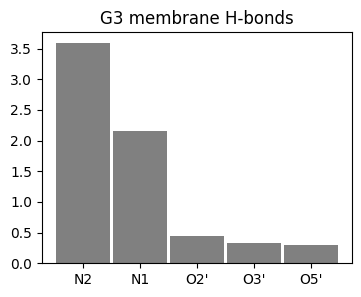

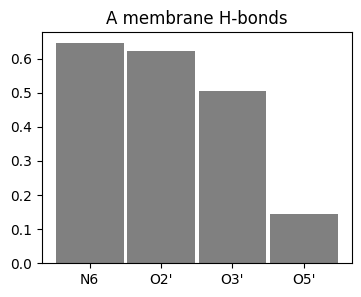

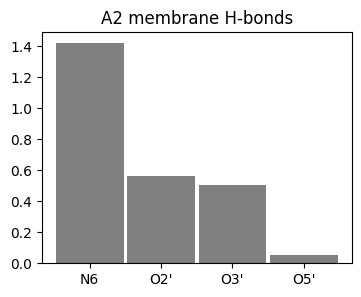

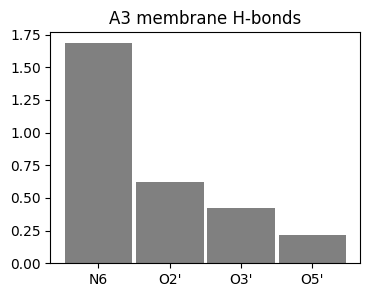

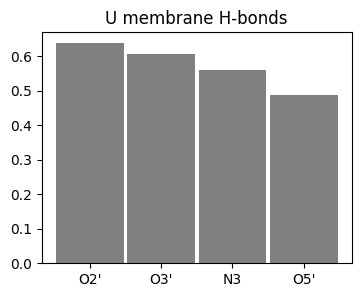

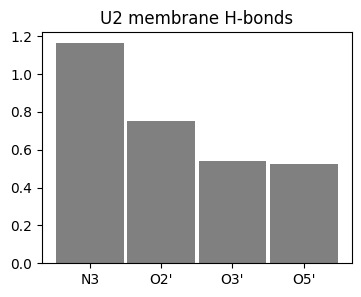

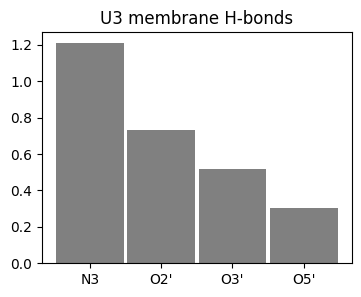

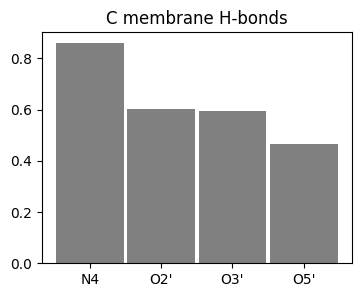

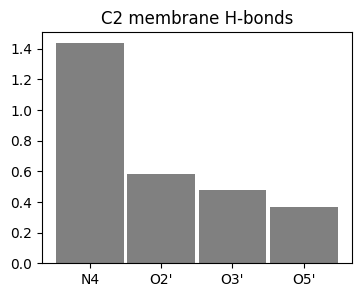

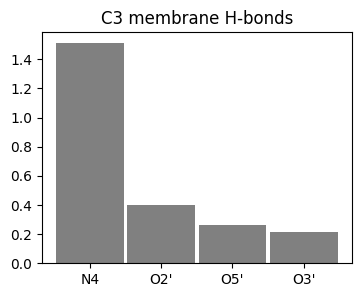

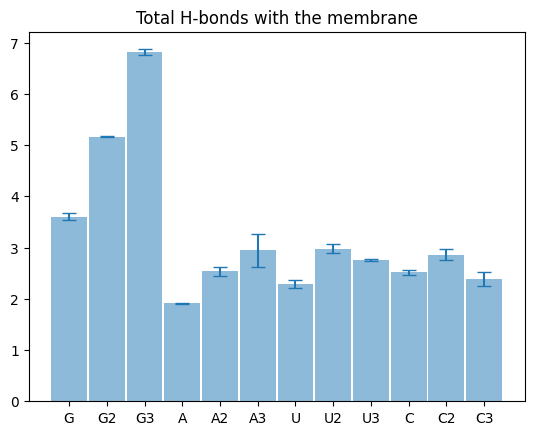

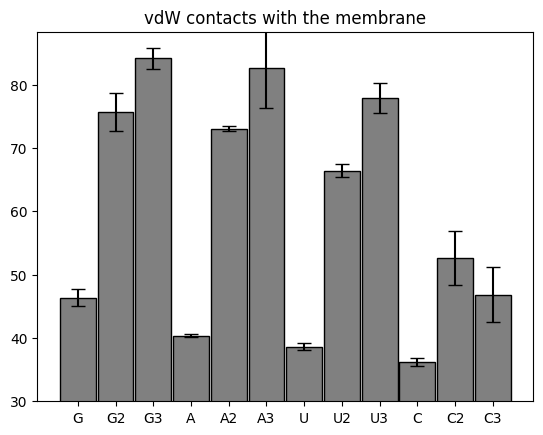

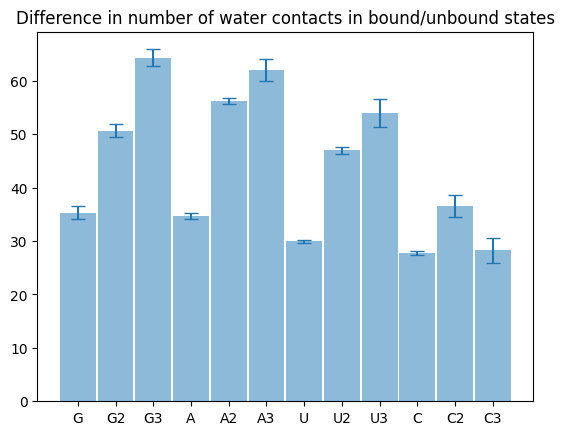

In [5]:
nucls=["G","G2","G3","A","A2","A3","U","U2","U3","C","C2","C3"]

hbonds_memb=[]
err_hbonds_memb=[]

hbonds_wat=[]
err_hbonds_wat=[]

vdws_memb=[]
errs_vdw=[]

vdws_wat=[]
errs_vdw_wat=[]

vdws_wat_unbound=[]
errs_vdw_wat_unbound=[]

diff_vdws=[]
errs_diff_vdw=[]
for nucl in nucls:
    weights=np.loadtxt(path+"bound/inputs/weights_bound_"+nucl)
    zdists=np.loadtxt(path+"bound/inputs/zdists_bound_"+nucl)

    vdw_memb = np.loadtxt(path+"bound/vdw/vdw_rna_memb_"+nucl+".dat") #this has already subracted formed hbonds from it.
    avg_vdw,error_vdw=compute_avgs(vdw_memb,zdists,weights)
    vdws_memb.append(avg_vdw)
    errs_vdw.append(error_vdw)

    vdw_wat=np.loadtxt(path+"bound/vdw/vdw_rna_wat_"+nucl+".dat")
    avg_vdw_wat,error_vdw_wat=compute_avgs(vdw_wat,zdists,weights)
    vdws_wat.append(avg_vdw_wat)
    errs_vdw_wat.append(error_vdw_wat)

    vdw_wat_unbound=np.loadtxt(path+"unbound/vdw/vdw_rna_wat_unbound_"+nucl+".dat")
    vdws_wat_unbound.append(np.average(vdw_wat_unbound))
    errs_vdw_wat_unbound.append(np.std(vdw_wat_unbound/np.sqrt(len(vdw_wat_unbound)))) #Error of the mean is done like this because frames are quite uncorrelated+ weights are similar for all these frames One could anyways perform bayesian bootstrap with the code above.
    err_vdw_wat_unbound=np.std(vdw_wat_unbound/np.sqrt(len(vdw_wat_unbound)))

    diff_vdws.append(np.average(vdw_wat_unbound)-avg_vdw_wat)
    errs_diff_vdw.append(np.sqrt(err_vdw_wat_unbound**2+error_vdw_wat**2))

        
    totnum_memb,acceptors=hbonds_mda(nucl,weights,zdists)
    avg_hbond_memb,error_hbond_memb=compute_avgs(totnum_memb,zdists,weights)
    hbonds_memb.append(avg_hbond_memb)
    err_hbonds_memb.append(error_hbond_memb)


    f=plt.figure()
    plt.title(nucl+' membrane H-bonds')
    f.set_figwidth(4)
    f.set_figheight(3)
    donors_list=[]
    acceptors_list=[]
    perc_list=[]
    perc_list_acc=[]
    moieties_list=[]
    perc_list_wat=[]
    for donor in acceptors:
        donors_list.append(donor)
        perc_list.append(acceptors[donor])

    indices_acc=np.argsort(perc_list_acc)[::-1]
    indices=np.argsort(perc_list)[::-1]
    donors_list=np.asarray(donors_list)

    perc_list=np.asarray(perc_list)
    perc_list_acc=np.asarray(perc_list_acc)
    plt.bar(donors_list[indices],perc_list[indices],width=0.95,align='center',color='gray')   
    plt.show()

plt.title("Total H-bonds with the membrane")
plt.bar(nucls,hbonds_memb,width=0.95,alpha=0.5)
plt.errorbar(nucls,hbonds_memb,yerr=err_hbonds_memb,fmt='none',barsabove=True,capsize=5)
plt.show()

plt.title("vdW contacts with the membrane")
plt.bar(nucls,vdws_memb,width=0.95,label='#vdw contact with memb',color='gray',edgecolor='black')
plt.ylim(bottom=30)
plt.errorbar(nucls,vdws_memb,yerr=errs_vdw,c='black',fmt='none',barsabove=True,capsize=5)
plt.show()

plt.title("Difference in number of water contacts in bound/unbound states")
plt.bar(nucls,-np.array(vdws_wat)+np.array(vdws_wat_unbound),width=0.95,label='#vdw with wat',alpha=0.5)
plt.errorbar(nucls,-np.array(vdws_wat)+np.array(vdws_wat_unbound),yerr=np.array(errs_diff_vdw),fmt='none',barsabove=True,capsize=5)
plt.show()

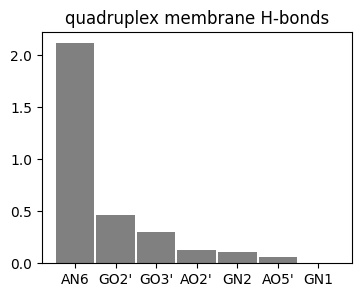

Total H-bonds with the membrane: 3.1733940984477242
vdW contacts with the membrane: 137.7166075504431


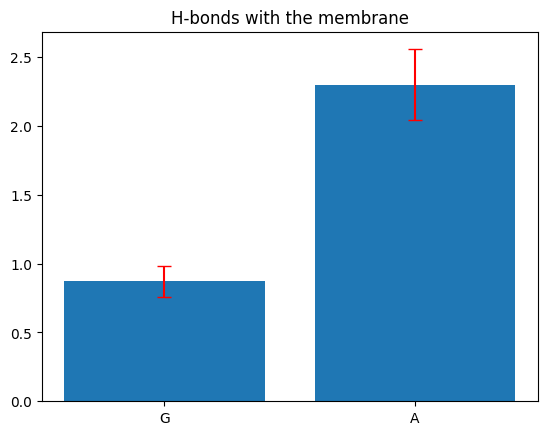

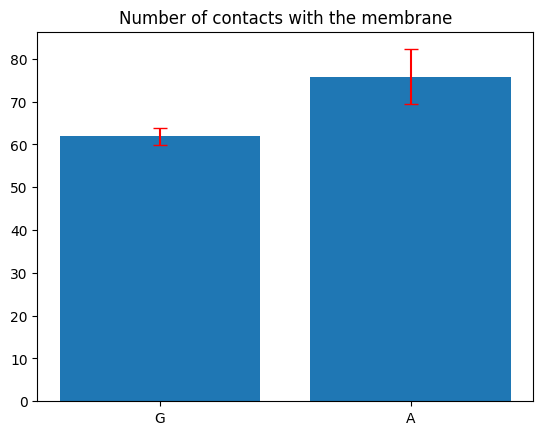

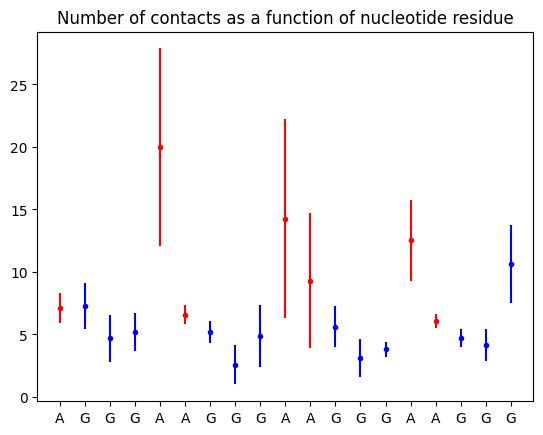

In [ ]:
nucl="quadruplex"

weights=np.loadtxt(path+"bound/inputs/weights_bound_"+nucl)
zdists=np.loadtxt(path+"bound/inputs/zdists_bound_"+nucl)

vdw_memb = np.loadtxt(path+"bound/vdw/vdw_rna_memb_"+nucl+".dat") #this has already subracted formed hbonds from it.
avg_vdw,error_vdw=compute_avgs(vdw_memb,zdists,weights)


vdw_wat=np.loadtxt(path+"bound/vdw/vdw_rna_wat_"+nucl+".dat")
avg_vdw_wat,error_vdw_wat=compute_avgs(vdw_wat,zdists,weights)
 
totnum_memb,acceptors,nG,nA,hbond_by_res=hbonds_mda(nucl,weights,zdists,byresidue=True)
avg_hbond_memb,error_hbond_memb=compute_avgs(totnum_memb,zdists,weights)

avg_nG,err_nG=compute_avgs(nG,zdists,weights)
avg_nA,err_nA=compute_avgs(nA,zdists,weights)


f=plt.figure()
plt.title(nucl+' membrane H-bonds')
f.set_figwidth(4)
f.set_figheight(3)
donors_list=[]
acceptors_list=[]
perc_list=[]
perc_list_acc=[]
moieties_list=[]
perc_list_wat=[]
for donor in acceptors:
    donors_list.append(donor)
    perc_list.append(acceptors[donor])

indices_acc=np.argsort(perc_list_acc)[::-1]
indices=np.argsort(perc_list)[::-1]
donors_list=np.asarray(donors_list)
acceptors_list=np.asarray(acceptors_list)

perc_list=np.asarray(perc_list)
perc_list_acc=np.asarray(perc_list_acc)
plt.bar(donors_list[indices],perc_list[indices],width=0.95,align='center',color='gray')   
plt.show()
print("Total H-bonds with the membrane: "+str(avg_hbond_memb))
print("vdW contacts with the membrane: "+str(avg_vdw))

plt.title("H-bonds with the membrane")
plt.bar(["G","A"],[avg_nG,avg_nA])
plt.errorbar(["G","A"],[avg_nG,avg_nA],yerr=[err_nG,err_nA],fmt='none',barsabove=True,capsize=5,ecolor='red')
plt.show()

contactsbyresidue=np.loadtxt(path+"bound/vdw/res_contacts_list_"+nucl+".dat")
string="AGGGAAGGGAAGGGAAGGG"
contacts=np.zeros((len(contactsbyresidue),2))
list=[str_nucl for str_nucl in string]
for i_list,a_list in enumerate(contactsbyresidue):
    nAvdw=0
    nGvdw=0
    for i_str,str_nucl in enumerate(list):
        if str_nucl=="A":
            nAvdw+=a_list[i_str]
        else:
            nGvdw+=a_list[i_str]
    contacts[i_list,0]=nGvdw
    contacts[i_list,1]=nAvdw
avg_nGvdw,err_nGvdw=compute_avgs(contacts[:,0]-nG,zdists,weights)#hbonds subtracted
avg_nAvdw,err_nAvdw=compute_avgs(contacts[:,1]-nA,zdists,weights)
plt.title("Number of contacts with the membrane")
plt.bar(["G","A"],[avg_nGvdw,avg_nAvdw])
plt.errorbar(["G","A"],[avg_nGvdw,avg_nAvdw],yerr=[err_nGvdw,err_nAvdw],fmt='none',barsabove=True,capsize=5,ecolor='red')
plt.show()

avgs=np.zeros(19)
errs=np.zeros(19)
for i in range(19):
    avgs[i],errs[i]=compute_avgs(contactsbyresidue[:,i]-hbond_by_res[:,i],zdists,weights)
string="AGGGAAGGGAAGGGAAGGG"
totnum=np.zeros(2)
list=[str for str in string]
for i_str,str_nucl in enumerate(list):
    if str_nucl=="A":
        plt.plot(i_str,avgs[i_str],marker='.',color='red')
        plt.errorbar(i_str,avgs[i_str],yerr=errs[i_str],color='red')
        totnum[0]+=avgs[i_str]
    else:
        plt.plot(i_str,avgs[i_str],marker='.',color='blue')
        plt.errorbar(i_str,avgs[i_str],yerr=errs[i_str],color='blue')
        totnum[1]+=avgs[i_str]
#plt.plot(avgs,'o')

plt.xticks(ticks=np.arange(0,19,1),labels=list)
plt.title("Number of contacts as a function of nucleotide residue")
plt.show()

In [15]:
np.average(hbond_by_res,axis=0)

array([0.18857983, 0.10035535, 0.01164073, 0.00624923, 0.75407426,
       0.1470408 , 0.04068129, 0.00171548, 0.09484132, 0.40374954,
       0.25952702, 0.03161377, 0.        , 0.00894498, 0.35179512,
       0.17167014, 0.01482661, 0.01372381, 0.56488175])

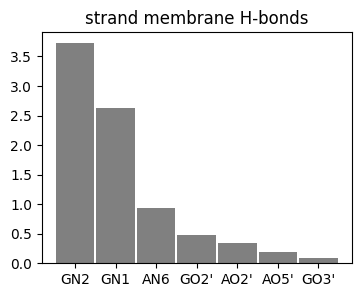

Total H-bonds with the membrane: 8.38328036289715
vdW contacts with the membrane: 175.71732731769947


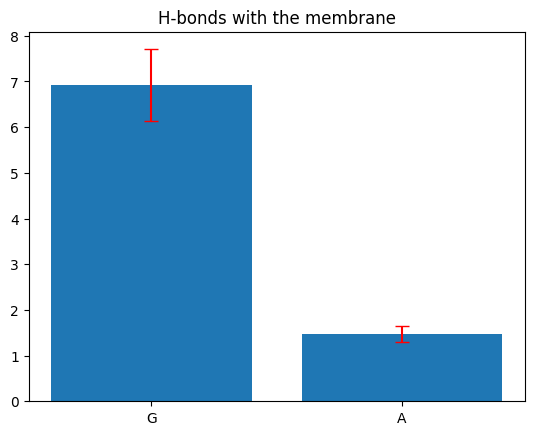

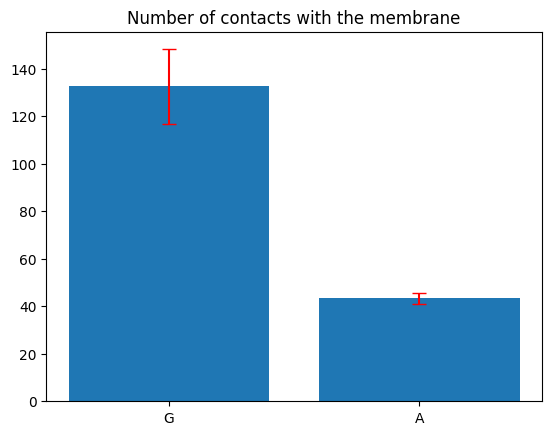

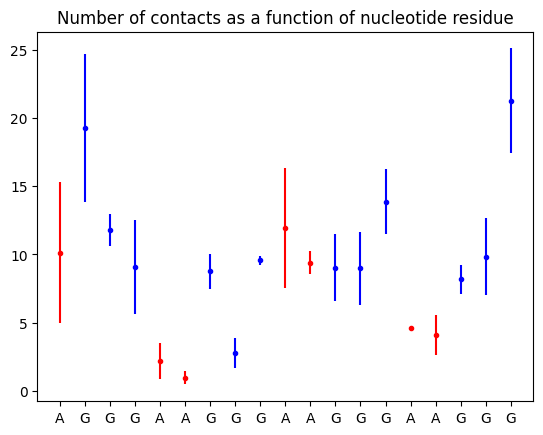

In [ ]:
nucl="strand"

weights=np.loadtxt(path+"bound/inputs/weights_bound_"+nucl)
zdists=np.loadtxt(path+"bound/inputs/zdists_bound_"+nucl)

vdw_memb = np.loadtxt(path+"bound/vdw/vdw_rna_memb_"+nucl+".dat") #this has already subracted formed hbonds from it.
avg_vdw,error_vdw=compute_avgs(vdw_memb,zdists,weights)

vdw_wat=np.loadtxt(path+"bound/vdw/vdw_rna_wat_"+nucl+".dat")
avg_vdw_wat,error_vdw_wat=compute_avgs(vdw_wat,zdists,weights)
 
totnum_memb,acceptors,nG,nA,hbond_by_res=hbonds_mda(nucl,weights,zdists,byresidue=True)
avg_hbond_memb,error_hbond_memb=compute_avgs(totnum_memb,zdists,weights)

avg_nG,err_nG=compute_avgs(nG,zdists,weights)
avg_nA,err_nA=compute_avgs(nA,zdists,weights)


f=plt.figure()
plt.title(nucl+' membrane H-bonds')
f.set_figwidth(4)
f.set_figheight(3)
donors_list=[]
acceptors_list=[]
perc_list=[]
perc_list_acc=[]
moieties_list=[]
perc_list_wat=[]
for donor in acceptors:
    donors_list.append(donor)
    perc_list.append(acceptors[donor])

indices_acc=np.argsort(perc_list_acc)[::-1]
indices=np.argsort(perc_list)[::-1]
donors_list=np.asarray(donors_list)
acceptors_list=np.asarray(acceptors_list)

perc_list=np.asarray(perc_list)
perc_list_acc=np.asarray(perc_list_acc)
plt.bar(donors_list[indices],perc_list[indices],width=0.95,align='center',color='gray')   
plt.show()
print("Total H-bonds with the membrane: "+str(avg_hbond_memb))
print("vdW contacts with the membrane: "+str(avg_vdw))

plt.title("H-bonds with the membrane")
plt.bar(["G","A"],[avg_nG,avg_nA])
plt.errorbar(["G","A"],[avg_nG,avg_nA],yerr=[err_nG,err_nA],fmt='none',barsabove=True,capsize=5,ecolor='red')
plt.show()

contactsbyresidue=np.loadtxt(path+"bound/vdw/res_contacts_list_"+nucl+".dat")
string="AGGGAAGGGAAGGGAAGGG"
contacts=np.zeros((len(contactsbyresidue),2))
list=[str_nucl for str_nucl in string]
for i_list,a_list in enumerate(contactsbyresidue):
    nAvdw=0
    nGvdw=0
    for i_str,str_nucl in enumerate(list):
        if str_nucl=="A":
            nAvdw+=a_list[i_str]
        else:
            nGvdw+=a_list[i_str]
    contacts[i_list,0]=nGvdw
    contacts[i_list,1]=nAvdw
avg_nGvdw,err_nGvdw=compute_avgs(contacts[:,0]-nG,zdists,weights)#hydrogen bonds are subtracted
avg_nAvdw,err_nAvdw=compute_avgs(contacts[:,1]-nA,zdists,weights)#also here
plt.title("Number of contacts with the membrane")
plt.bar(["G","A"],[avg_nGvdw,avg_nAvdw])
plt.errorbar(["G","A"],[avg_nGvdw,avg_nAvdw],yerr=[err_nGvdw,err_nAvdw],fmt='none',barsabove=True,capsize=5,ecolor='red')
plt.show()

avgs=np.zeros(19)
errs=np.zeros(19)
for i in range(19):
    avgs[i],errs[i]=compute_avgs(contactsbyresidue[:,i]-hbond_by_res[:,i],zdists,weights)
string="AGGGAAGGGAAGGGAAGGG"
totnum=np.zeros(2)
list=[str for str in string]
for i_str,str_nucl in enumerate(list):
    if str_nucl=="A":
        plt.plot(i_str,avgs[i_str],marker='.',color='red')
        plt.errorbar(i_str,avgs[i_str],yerr=errs[i_str],color='red')
        totnum[0]+=avgs[i_str]
    else:
        plt.plot(i_str,avgs[i_str],marker='.',color='blue')
        plt.errorbar(i_str,avgs[i_str],yerr=errs[i_str],color='blue')
        totnum[1]+=avgs[i_str]
#plt.plot(avgs,'o')

plt.xticks(ticks=np.arange(0,19,1),labels=list)
plt.title("Number of contacts as a function of nucleotide residue")
plt.show()